In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = (SparkSession.builder
         .master("spark://spark-master:7077")
         .appName("delta-test")
         .getOrCreate())

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /opt/spark/ivy/cache
The jars for the packages stored in: /opt/spark/ivy/jars
org.apache.spark#spark-hadoop-cloud_2.13 added as a dependency
io.delta#delta-spark_2.13 added as a dependency
org.apache.iceberg#iceberg-spark-runtime-4.0_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-79a9edb7-d2ef-415b-acde-52004d13cc70;1.0
	confs: [default]
	found org.apache.spark#spark-hadoop-cloud_2.13;4.0.1 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.hadoop#hadoop-aws;3.4.1 in central
	found org.wildfly.openssl#wildfly-openssl;2.2.5.Final in central
	found s

In [3]:
spark.sql("SHOW DATABASES").show(truncate=False)

26/01/11 14:05:50 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
26/01/11 14:06:45 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
26/01/11 14:06:45 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.18.0.6


+---------+
|namespace|
+---------+
|default  |
|silver   |
+---------+



In [4]:
spark.sql("SHOW TABLES IN silver").show(truncate=False)

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|silver   |flights  |false      |
+---------+---------+-----------+



In [5]:
df = spark.read \
    .format("delta") \
    .table("silver.flights")

In [6]:
df.show()

26/01/11 14:06:57 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 8:>                                                          (0 + 1) / 1]

+--------+-----+--------+------+-----------+--------------+
|    date|delay|distance|origin|destination|ingestion_date|
+--------+-----+--------+------+-----------+--------------+
|02151800|  108|     290|   ORD|        MSP|    2026-01-11|
|02151800|  142|     772|   ORD|        DEN|    2026-01-11|
|02151303|   16|    1516|   ORD|        LAX|    2026-01-11|
|02151157|    7|    1316|   ORD|        LAS|    2026-01-11|
|02151818|   55|    1511|   ORD|        PDX|    2026-01-11|
|02151033|   12|     873|   ORD|        MCO|    2026-01-11|
|02150941|    0|    1499|   ORD|        SNA|    2026-01-11|
|02151320|   17|    1604|   ORD|        SFO|    2026-01-11|
|02151804|    2|    1497|   ORD|        SAN|    2026-01-11|
|02152000|   17|     119|   ORD|        GRR|    2026-01-11|
|02151502|   15|     260|   ORD|        DSM|    2026-01-11|
|02151935|   73|     879|   ORD|        TPA|    2026-01-11|
|02151315|   -1|     879|   ORD|        TPA|    2026-01-11|
|02150957|    0|     939|   ORD|        

In [7]:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- delay: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- ingestion_date: date (nullable = true)



In [8]:
from pyspark.sql.functions import col, avg

df_agg = (
    df
    .withColumn("delay_int", col("delay").cast("int"))
    .groupBy("origin")
    .agg(avg("delay_int").alias("avg_delay"))
    .orderBy(col("avg_delay").desc())
)

In [9]:
pdf = df_agg.toPandas()

In [10]:
import plotly.express as px

In [11]:
fig = px.bar(
    pdf,
    x="origin",
    y="avg_delay",
    title="Retraso medio por aeropuerto de origen",
    labels={
        "origin": "Aeropuerto de origen",
        "avg_delay": "Retraso medio (minutos)"
    }
)

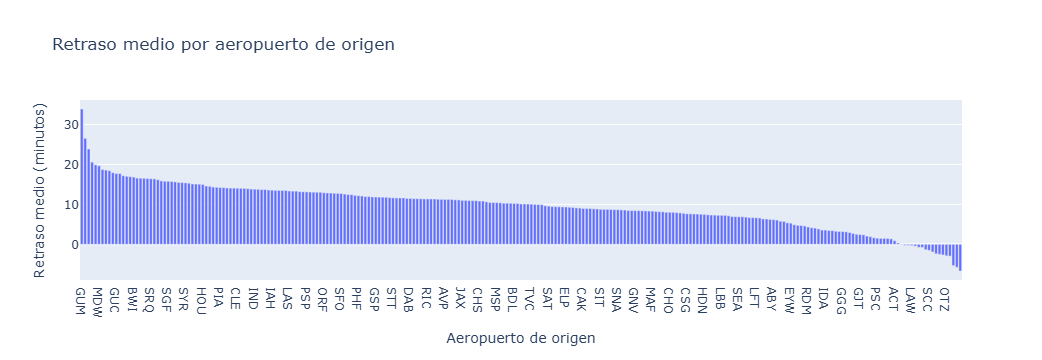

In [12]:
fig.show()

In [13]:
spark.stop()